In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
from scipy.spatial import distance
from tensorflow.keras.models import  load_model
import sys


#Utilities
def blur(image, k_size, gauss_sigma):    
    blurred = cv2.GaussianBlur(image, (k_size,k_size), gauss_sigma )
    return blurred

def get_boundary_pid(f, xmin, xmax, ymin, ymax):
    mask = (
        (f['x'] < xmin) | (f['x'] > xmax) |
        (f['y'] < ymin) | (f['y'] > ymax)
    )
    boundary_pid = f.particle[mask].to_numpy()
    return boundary_pid

def process_singular_bonds(F_out, boundary_pid):
    F_out = F_out.copy()
    boundary_pid = np.array(boundary_pid)
    F_out['singular'] = False

    # Step 1: Count all appearances
    all_particles = pd.concat([F_out['i'], F_out['j']])
    counts = all_particles.value_counts()

    # Find bulk particles that appear only once
    bulk_particles = counts.index.difference(boundary_pid)
    singular_particles = bulk_particles[counts[bulk_particles] == 1]

    # Step 2: Drop rows where both i and j are singular
    i_singular = F_out['i'].isin(singular_particles)
    j_singular = F_out['j'].isin(singular_particles)
    both_singular = i_singular & j_singular
    F_out = F_out[~both_singular].reset_index(drop=True)

    # Step 3: Mark singular column with the singular index (if any), else False
    F_out['singular'] = F_out.apply(
        lambda row: row['i'] if row['i'] in singular_particles else (row['j'] if row['j'] in singular_particles else -1),
        axis=1
    )

    return F_out


def drop_bulk_duplicate(df, boundary_pid):
    bulk_mask = (~df['i'].isin(boundary_pid)) & (~df['j'].isin(boundary_pid))
    # Create a key for each pair (min, max) so (i, j) and (j, i) are treated the same
    df['pair_key'] = list(zip(df[['i', 'j']].min(axis=1), df[['i', 'j']].max(axis=1)))
    # Keep only the first occurrence of each pair_key where both are not boundary
    keep_mask = ~(bulk_mask & df.duplicated('pair_key'))
    df = df[keep_mask].reset_index(drop=True)
    df = df.drop(columns='pair_key')
    return df


def crop_tangent_square(img, center, angle_rad, crop_size):
    """
    crop a rotated roi so the contact lies at the bottom of image
    """
    # Step 1: Get rotation matrix
    M = cv2.getRotationMatrix2D(center, np.degrees(angle_rad)-90, 1.0)
    
    # Step 2: Rotate the image about the contact point
    rotated = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
    
    # Step 3: Crop the square region
    x, y = int(center[0]), int(center[1])
    half = crop_size // 2
    cropped = rotated[y-half:y+half, x-half:x+half]
    return cropped


def duplicate_and_swap_bulk(F_out):
    """
    For all rows where j is NOT on the boundary, duplicate the row and swap i/j and their associated columns.
    The original rows are kept; the swapped rows are appended.
    """
    # Identify rows where j is not on the boundary
    to_duplicate = F_out[~F_out['j_on_boundary']].copy()

    # Columns to swap
    swap_cols = {
        'i': 'j', 'xi': 'xj', 'yi': 'yj', 'ri': 'rj',
        'j': 'i', 'xj': 'xi', 'yj': 'yi', 'rj': 'ri'
    }
    # Keep all columns, swap only those present in DataFrame
    swap_cols = {k: v for k, v in swap_cols.items() if k in F_out.columns and v in F_out.columns}
    other_cols = [col for col in F_out.columns if col not in swap_cols]

    # Swap columns
    swapped = to_duplicate.rename(columns=swap_cols)
    swapped = swapped[[*swap_cols.keys(), *other_cols]]  # preserve column order

    # Concatenate original and swapped
    F_out = pd.concat([F_out, swapped], ignore_index=True)
    return F_out


def get_all_bonds(f, boundary_pid, d_tol):
    """
    Efficiently get all possible contacts based on distance, no G2 thresh
    """
    coords = f[['x', 'y']].to_numpy()
    radii = f['rpx'].to_numpy()
    pid = f['particle'].to_numpy()

    # Distance matrix
    dist_mat = distance.cdist(coords, coords)
    r_mat = radii[:, None] + radii[None, :]

    # Boolean neighbor mask
    nbrs_bool = (dist_mat < r_mat + d_tol) & (dist_mat > 0)
    nbr_i, nbr_j = np.where(nbrs_bool)

    # Preallocate result array (avoid DataFrame.append in loop)
    n_contacts = len(nbr_i)
    result = np.empty((n_contacts, 8), dtype=float)

    result[:, 0] = pid[nbr_i]
    result[:, 1:3] = coords[nbr_i]
    result[:, 3] = radii[nbr_i]
    result[:, 4] = pid[nbr_j]
    result[:, 5:7] = coords[nbr_j]
    result[:, 7] = radii[nbr_j]

    # Create DataFrame at once
    F_out = pd.DataFrame(result, columns=['i', 'xi', 'yi', 'ri', 'j', 'xj', 'yj', 'rj'])
    F_out[['i', 'j']] = F_out[['i', 'j']].astype(int)

    # Filter out boundary i
    F_out = F_out[~F_out['i'].isin(set(boundary_pid))].reset_index(drop=True)

    # Drop one of each (i, j) and (j, i) pair where both i and j are not in boundary_idx
    F_out = drop_bulk_duplicate(F_out, boundary_pid)

    # Mark j_on_boundary
    F_out['j_on_boundary'] = F_out['j'].isin(boundary_pid)

    # Sort by i
    F_out = F_out.sort_values(by='i').reset_index(drop=True)

    return F_out, f, nbr_i, nbr_j

def predict_contact_batch(f_bond_frame, I, model, plot_raw, batch_size=32):
    """
    Cut and preprocess all contact regions from f_bond_frame into (128,128,3) images,
    then run them through the model in a single batch.

    """

    n = len(f_bond_frame)
    batch_crops = np.empty((n, 128, 128, 3), dtype=np.uint8)

    for idx, row in enumerate(f_bond_frame.itertuples(index=False)):
        # Compute particle centers and bond direction
        center_x = int(row.xi) 
        center_y = int(row.yi) 
        center_jx = int(row.xj) 
        center_jy = int(row.yj) 

        angle = np.arctan2(center_jy - center_y, center_jx - center_x)
        ri = row.ri
        crop_size = int(1.2 * ri)

        # Compute contact point (on the perimeter of particle i)
        x1 = int(center_x + ri * np.cos(angle))
        y1 = int(center_y + ri * np.sin(angle))

        # Crop the image region tangent to the bond
        cropped = crop_tangent_square(I, (x1, y1), angle, crop_size)

        # Resize to (128,128), convert grayscale to RGB, and normalize to [0,1]
        cropped = cv2.resize(cropped, (128, 128), interpolation=cv2.INTER_AREA)
        cropped = cv2.cvtColor(cropped, cv2.COLOR_GRAY2RGB)

        # Store the processed image and the particle pair (i, j)
        batch_crops[idx] = cropped

        if plot_raw: #PLOT LAST CROPPED IMAGE FOR REF
            plt.figure(figsize=(4,4))
            plt.imshow(cropped, cmap='gray')
            plt.show()

    # Run the model in a single batch
    preds = model.predict(batch_crops, batch_size=batch_size, verbose=1)

    return preds, batch_crops

#plotting

def plot_contacts(I, f, F_out, boundary_pid):
    """
    Plot image + particles + contacts.
    Returns an RGB image array (no display, no video write).
    """
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.imshow(I, cmap='gray')

    
    # Draw particles
    for _, row in f.iterrows():
        ax.add_patch(plt.Circle((row['x'], row['y']), row['rpx'], 
                                color='green', fill=False, linewidth=1))
        
    # Draw boundary particles
    for _, row in f[f.particle.isin(boundary_pid)].iterrows():
        ax.add_patch(plt.Circle((row['x'], row['y']), row['rpx'], 
                                color='red', fill=False, linewidth=1))
        
      # Draw real contacts
    for _, row in F_out.iterrows():
        ax.plot([row['xi'], row['xj']], [row['yi'], row['yj']], 
                color='cyan', linestyle = '--', linewidth=5, alpha = 0.5)      
        
     # Draw singular bonds
    for _, row in F_out[F_out.singular>0].iterrows():
        ax.plot([row['xi'], row['xj']], [row['yi'], row['yj']], 
                color='magenta', linestyle = '--', linewidth=2, alpha = 0.4)      
    
    
    ax.axis('off')

    fig.tight_layout()
    fig.canvas.draw()

    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    plt.close(fig)

    return img

def write_frame_to_video(I, f, F_out,boundary_pid, out_writer):
    """
    Generate frame using plot_contacts and write to video.
    """
    img = plot_contacts(I, f, F_out, boundary_pid)
    #img_resized = cv2.resize(img, (frame_width, frame_height))
    out_writer.write(img)




### Read in tracked file, find all bonds that have length < $r_i + r_j +$ d_tol

output is F_bond that contains all potential bonds and boundary information

1. No boundary particles is on i 
2. Bulk - Bulk bonds are only counted once
3. Bonds with j on boundary are noted

In [ ]:
################ INPUT EXPERIMENT NAME ######################

EXP_FOLDER = "TPE_20260122A01_N=265x2_5e-4rps_10fps_steady_2000frames"

###################### NO NEED TO EDIT BELOW ######################
###################### FILE SETTING ################################

TRAJ_DIR = r'M:\Archive\Proj_TPE\Disk_traj_files' # Directory of traj files
IMG_DIR = r'N:\PROJ_TPE' #directory of raw images

linked_file = os.path.join(TRAJ_DIR, f"{EXP_FOLDER}.pkl")
F = pd.read_pickle(linked_file)
PE_dir = os.path.join(IMG_DIR, EXP_FOLDER)
filetype = r".png"
backgnd_path = r"N:\PROJ_TPE\TPE_20250709_bw_bckgnd.png"

##################### PARAMS ######################################
roi = (250,1200, 0, 2000) #ROI FOR in y and x direction
d_tol = 10 # tolerance distance for neighbor threshold

#################### TOGGLE SWITCHES ###############################
plot = 0 # 1 TO DISPLAT POSITIONS AND BONDS ON RAW IMAGE
###################################################################

F_bond = []

for frame in range(1, int(F.frame.max())+1):

    #TRACK PROGRESS
    sys.stdout.write(f"\rProcessing frame: {frame}")
    sys.stdout.flush()

    PE_img_path = os.path.join(PE_dir, 'Ib_' + str(frame+1)+ filetype)
    I =  cv2.imread(PE_img_path, cv2.IMREAD_GRAYSCALE)[roi[0]:roi[1], roi[2]:roi[3]] #for inspection and plotting only
    f = F[F.frame == frame].reset_index(drop=True)
    boundary_pid = f.particle[f.boundary].to_numpy() #boundary index named in particle id

############ BUILD BOND DATAFRAME #######################
    F_bond_temp, f, nbr_i, nbr_j = get_all_bonds(f, boundary_pid,  d_tol)
    
    F_bond_temp['frame'] = frame
    F_bond.append(F_bond_temp)

       
F_bond = pd.concat(F_bond, ignore_index=True)

############## PLOT IF DESIRED ############################

if plot:
    plt.figure(figsize=(16, 9))
    img = plot_contacts(I, f, F_bond, boundary_pid)
    plt.imshow(img)
    plt.axis('off')


Processing frame: 2000

### Use model to distinguish contact or not, add contact column to F_bond

Cropped square has sides = $1.2 r_i$ 

Each contact point is only examined once

If both particles only have one contact (i.e. singular), the contact is deleted.

If either particle is singular, the contact is kept. The singular id is marked in the "singular" column

If neither are singular, singular column writes -1

Finally, ij pairs that are not on the boundary are cloned and swapped to ji

In [ ]:
#LOAD MODEL
model_path = os.path.join(os.getcwd(), 'models', 'Contact_Detect_VGG19_20251127.h5')
model = load_model(model_path)

In [ ]:
all_frames = []

for frame in range(1, int(F.frame.max())+1):
#for frame in [242]: # this frame is for testing

    #TRACK PROGRESS
    sys.stdout.write(f"\rProcessing frame: {frame}")
    sys.stdout.flush()

    #Load position data
    f = F[F.frame==frame].copy() #invoke position data again to distinguish boundary particles
    boundary_pid = f.particle[f.boundary].to_numpy()

    # Load image
    PE_img_path = os.path.join(PE_dir, f'Ib_{frame+1}{filetype}')
    I = cv2.imread(PE_img_path, cv2.IMREAD_GRAYSCALE)[roi[0]:roi[1], roi[2]:roi[3]]

    # Filter bonds for this frame
    f_bond_frame = F_bond[F_bond.frame == frame].copy()

    #PREDICT
    preds, batch_crops = predict_contact_batch(f_bond_frame, I, model, plot_raw=False, batch_size=32)

    # Assume preds is (N, 2) 
    if preds.ndim == 2:
        pred_class = np.argmax(preds, axis=1)
        pred_prob = np.max(preds, axis=1)
        f_bond_frame['contact'] = pred_class
        f_bond_frame['prob'] = pred_prob

    else: 
        raise ValueError("Predictions should be 2D array with shape (N, 2)")
    
    # Keep ceritfied contacts
    f_bond_frame = f_bond_frame[f_bond_frame.contact > 0]  

    #mark any singular bonds
    f_bond_frame = process_singular_bonds(f_bond_frame, boundary_pid)

    # duplicate and swap bulk ids
    f_bond_frame = duplicate_and_swap_bulk(f_bond_frame)
         
    # Append to list
    all_frames.append(f_bond_frame)


# Combine into one big DataFrame
F_contact = pd.concat(all_frames, ignore_index=True)
F_contact = F_contact.drop(columns = ['contact'])


### Inspect results in one frame

Normal contacts in cyan

Singular contacts in magenta

3.189655172413793


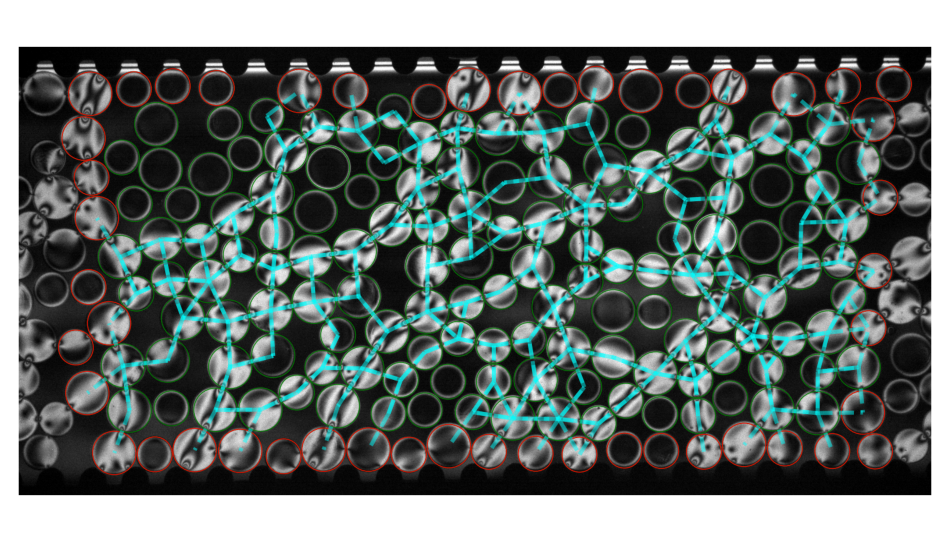

In [15]:
for frame in [1242]: # this frame is for testing

    PE_img_path = os.path.join(PE_dir, f'Ib_{frame+1}{filetype}')
    I = cv2.imread(PE_img_path, cv2.IMREAD_GRAYSCALE)[roi[0]:roi[1], roi[2]:roi[3]]
    f = F[F.frame==frame].copy() 

    contact = F_contact[F_contact.frame==frame]['i'].value_counts()
    z = contact[contact > 1].mean()
    print(z)

    plt.figure(figsize=(12, 8))
    plt.imshow(plot_contacts(I, f, F_contact[F_contact.frame==frame], f.particle[f.boundary].to_numpy()))
    plt.axis('off')


### Save results to disk

In [16]:
bond_dir = r'M:\Archive\Proj_TPE\Contact_bond_files' 
out_filename = f"CONTACT_BOND_{experiment_name}.pkl"
F_contact.to_pickle(os.path.join(bond_dir, out_filename))
F_contact

,i,xi,yi,ri,j,xj,yj,rj,j_on_boundary,frame,prob,singular
0,0,523.784941,768.041516,46.0,54,503.260350,685.852523,37.0,False,1,0.943580,-1
1,0,523.784941,768.041516,46.0,96,460.562346,842.824340,46.0,True,1,0.949868,-1
2,0,523.784941,768.041516,46.0,140,564.402983,854.466702,46.0,True,1,0.931758,-1
3,0,523.784941,768.041516,46.0,144,595.847513,704.255497,46.0,False,1,0.936995,-1
4,1,1666.335426,448.065627,37.0,5,1685.589367,520.510343,37.0,False,1,0.939053,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
744142,181,477.801313,318.805600,46.0,173,511.448441,229.273774,46.0,False,2000,0.968141,-1
744143,199,1785.690769,211.968952,37.0,176,1707.957686,249.402377,46.0,False,2000,0.926735,-1
744144,190,1477.742972,375.141210,46.0,183,1384.362982,390.218443,46.0,False,2000,0.952615,-1
744145,193,258.904195,703.475401,46.0,191,332.721316,763.332174,46.0,False,2000,0.918241,-1
